<a href="https://colab.research.google.com/github/JSJeong-me/GPT_Ochestration/blob/main/01-gpt4v_multi_modal_retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/run-llama/llama_index/blob/main/docs/examples/multi_modal/gpt4v_multi_modal_retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Multi-Modal Retrieval using GPT4V and Multi-Modal Index/Retriever

In this notebook, we show how to build a Multi-Modal retrieval system using LlamaIndex with GPT4-V and CLIP.

LlamaIndex Multi-Modal Retrieval

- Text embedding index: Generate GPT text embeddings
- Images embedding index: [CLIP](https://github.com/openai/CLIP) embeddings from OpenAI for images


Encoding queries:
* Encode query text for text index using ada
* Encode query text for image index using CLIP

Framework: [LlamaIndex](https://github.com/run-llama/llama_index)

Steps:
1. Using Multi-Modal LLM GPT4V class to undertand multiple images
2. Download texts, images, pdf raw files from related Wikipedia articles and SEC 10K report
2. Build Multi-Modal index and vetor store for both texts and images
4. Retrieve relevant text and image simultaneously using Multi-Modal Retriver according to the image reasoning from Step 1

In [ ]:
%pip install llama_index ftfy regex tqdm
%pip install git+https://github.com/openai/CLIP.git
%pip install torch torchvision
%pip install matplotlib scikit-image
%pip install -U qdrant_client

In [2]:
import os

OPENAI_API_TOKEN = "sk-"
os.environ["OPENAI_API_KEY"] = OPENAI_API_TOKEN

## Download images from Tesla website for GPT4V image reasoning

In [3]:
from pathlib import Path

input_image_path = Path("input_images")
if not input_image_path.exists():
    Path.mkdir(input_image_path)

In [ ]:
!wget "https://docs.google.com/uc?export=download&id=1nUhsBRiSWxcVQv8t8Cvvro8HJZ88LCzj" -O ./input_images/long_range_spec.png
!wget "https://docs.google.com/uc?export=download&id=19pLwx0nVqsop7lo0ubUSYTzQfMtKJJtJ" -O ./input_images/model_y.png
!wget "https://docs.google.com/uc?export=download&id=1utu3iD9XEgR5Sb7PrbtMf1qw8T1WdNmF" -O ./input_images/performance_spec.png
!wget "https://docs.google.com/uc?export=download&id=1dpUakWMqaXR4Jjn1kHuZfB0pAXvjn2-i" -O ./input_images/price.png
!wget "https://docs.google.com/uc?export=download&id=1qNeT201QAesnAP5va1ty0Ky5Q_jKkguV" -O ./input_images/real_wheel_spec.png

## Generate image reasoning from GPT4V Multi-Modal LLM

### Plot input images

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os

image_paths = []
for img_path in os.listdir("./input_images"):
    image_paths.append(str(os.path.join("./input_images", img_path)))


def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(2, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break


plot_images(image_paths)

### Using GPT4V to understand those input images

In [6]:
from llama_index.multi_modal_llms.openai import OpenAIMultiModal
from llama_index import SimpleDirectoryReader

# put your local directore here
image_documents = SimpleDirectoryReader("./input_images").load_data()

openai_mm_llm = OpenAIMultiModal(
    model="gpt-4-vision-preview", api_key=OPENAI_API_TOKEN, max_new_tokens=1500
)

response_1 = openai_mm_llm.complete(
    prompt="Describe the images as an alternative text",
    image_documents=image_documents,
)

print(response_1)

The images provided appear to be screenshots from a website showcasing specifications and details of an electric vehicle, likely from a car manufacturer's official site.

1. The first image displays a comparison chart between two variants of a vehicle, labeled "Performance" and "Long Range AWD." The chart lists various specifications such as battery type, acceleration, range, top speed, drive type, seating, wheels, and warranty details.

2. The second image shows a cutaway illustration of a vehicle, highlighting its structural components. The image is focused on the car's chassis and labels point to the "Rigid Structure" and "Impact Protection" features of the vehicle.

3. The third image is similar to the first one, providing a detailed list of specifications for the "Model Y" vehicle. It includes information about the battery, acceleration, range, top speed, drive type, seating, wheels, display, and warranty.

4. The fourth image is a pricing and savings information chart for the "Mo

In [ ]:
response_2 = openai_mm_llm.complete(
    prompt="Can you tell me what is the price with each spec?",
    image_documents=image_documents,
)

print(response_2)

## Generating text, pdf, images data from raw files [Wikipedia, SEC files] for Multi Modal Index/Retrieval

In [8]:
import requests


def get_wikipedia_images(title):
    response = requests.get(
        "https://en.wikipedia.org/w/api.php",
        params={
            "action": "query",
            "format": "json",
            "titles": title,
            "prop": "imageinfo",
            "iiprop": "url|dimensions|mime",
            "generator": "images",
            "gimlimit": "50",
        },
    ).json()
    image_urls = []
    for page in response["query"]["pages"].values():
        if page["imageinfo"][0]["url"].endswith(".jpg") or page["imageinfo"][
            0
        ]["url"].endswith(".png"):
            image_urls.append(page["imageinfo"][0]["url"])
    return image_urls

In [9]:
from pathlib import Path
import requests
import urllib.request

image_uuid = 0
# image_metadata_dict stores images metadata including image uuid, filename and path
image_metadata_dict = {}
MAX_IMAGES_PER_WIKI = 20

wiki_titles = {
    "Tesla Model Y",
    "Tesla Model X",
    "Tesla Model 3",
    "Tesla Model S",
    "Kia EV6",
    "BMW i3",
    "Audi e-tron",
    "Ford Mustang",
    "Porsche Taycan",
    "Rivian",
    "Polestar",
}


data_path = Path("mixed_wiki")
if not data_path.exists():
    Path.mkdir(data_path)

for title in wiki_titles:
    response = requests.get(
        "https://en.wikipedia.org/w/api.php",
        params={
            "action": "query",
            "format": "json",
            "titles": title,
            "prop": "extracts",
            "explaintext": True,
        },
    ).json()
    page = next(iter(response["query"]["pages"].values()))
    wiki_text = page["extract"]

    with open(data_path / f"{title}.txt", "w") as fp:
        fp.write(wiki_text)

    images_per_wiki = 0
    try:
        # page_py = wikipedia.page(title)
        list_img_urls = get_wikipedia_images(title)
        # print(list_img_urls)

        for url in list_img_urls:
            if (
                url.endswith(".jpg")
                or url.endswith(".png")
                or url.endswith(".svg")
            ):
                image_uuid += 1
                # image_file_name = title + "_" + url.split("/")[-1]

                urllib.request.urlretrieve(
                    url, data_path / f"{image_uuid}.jpg"
                )
                images_per_wiki += 1
                # Limit the number of images downloaded per wiki page to 15
                if images_per_wiki > MAX_IMAGES_PER_WIKI:
                    break
    except:
        print(str(Exception("No images found for Wikipedia page: ")) + title)
        continue

No images found for Wikipedia page: Tesla Model Y
No images found for Wikipedia page: Porsche Taycan
No images found for Wikipedia page: Tesla Model X
No images found for Wikipedia page: Audi e-tron
No images found for Wikipedia page: BMW i3
No images found for Wikipedia page: Tesla Model 3


In [10]:
!wget "https://www.dropbox.com/scl/fi/mlaymdy1ni1ovyeykhhuk/tesla_2021_10k.htm?rlkey=qf9k4zn0ejrbm716j0gg7r802&dl=1" -O ./mixed_wiki/tesla_2021_10k.htm

--2024-01-11 07:26:06--  https://www.dropbox.com/scl/fi/mlaymdy1ni1ovyeykhhuk/tesla_2021_10k.htm?rlkey=qf9k4zn0ejrbm716j0gg7r802&dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd4c865e7eca9913b85f1d41d96.dl.dropboxusercontent.com/cd/0/inline/CLK4sh2CUYQjzqfgRcWH1VT710sxfsUU5xGibFLKbv_grNu0JV1-g5mjrm2DlmFMhMorTP5VjP0rYARqxWmfUHNX7jgT8rQsbBAogBo9TXGw6E4X3YuZMU-RBx1XXNT0Ugc/file?dl=1# [following]
--2024-01-11 07:26:07--  https://ucd4c865e7eca9913b85f1d41d96.dl.dropboxusercontent.com/cd/0/inline/CLK4sh2CUYQjzqfgRcWH1VT710sxfsUU5xGibFLKbv_grNu0JV1-g5mjrm2DlmFMhMorTP5VjP0rYARqxWmfUHNX7jgT8rQsbBAogBo9TXGw6E4X3YuZMU-RBx1XXNT0Ugc/file?dl=1
Resolving ucd4c865e7eca9913b85f1d41d96.dl.dropboxusercontent.com (ucd4c865e7eca9913b85f1d41d96.dl.dropboxusercontent.com)... 162.125.80.15, 2620:100:6035:15::a27d:

## Build Multi-modal index and vector store to index both text and images

In [11]:
from llama_index.indices.multi_modal.base import MultiModalVectorStoreIndex
from llama_index.vector_stores import QdrantVectorStore
from llama_index import SimpleDirectoryReader, StorageContext

import qdrant_client
from llama_index import (
    SimpleDirectoryReader,
)


# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="qdrant_mm_db")

text_store = QdrantVectorStore(
    client=client, collection_name="text_collection"
)
image_store = QdrantVectorStore(
    client=client, collection_name="image_collection"
)
storage_context = StorageContext.from_defaults(
    vector_store=text_store, image_store=image_store
)

# Create the MultiModal index
documents = SimpleDirectoryReader("./mixed_wiki/").load_data()
index = MultiModalVectorStoreIndex.from_documents(
    documents,
    storage_context=storage_context,
)

# Save it
# index.storage_context.persist(persist_dir="./storage")

# # Load it
# from llama_index import load_index_from_storage

# storage_context = StorageContext.from_defaults(
#     vector_store=text_store, persist_dir="./storage"
# )
# index = load_index_from_storage(storage_context, image_store=image_store)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (101972528 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|███████████████████████████████████████| 338M/338M [00:06<00:00, 55.9MiB/s]
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (101972528 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [12]:
print(response_2.text)

The images you've provided show specifications and pricing for different variants of the Tesla Model Y. Here are the details for each variant:

1. Model Y Rear-Wheel Drive:
   - Battery: Long Range
   - Acceleration: 6.9 seconds 0-100 km/h
   - Range: 394 km (EPA est.)
   - Drive: Rear-Wheel Drive
   - Seating: Up to 5
   - Wheels: 19" or 20"
   - Weight: 1,909 kg
   - Cargo Volume: 2,158 liters
   - Top Speed: 217 km/h
   - Display: 15" Center Touchscreen
   - Power: 170 kW
   - Warranty: Basic Vehicle - 4 years or 80,000 km, whichever comes first
   - Price: $57,990

2. Model Y Long Range AWD:
   - Battery: Long Range
   - Acceleration: 5.0 seconds 0-100 km/h
   - Range: 497 km (EPA est.)
   - Drive: Dual Motor All-Wheel Drive
   - Seating: Up to 5
   - Wheels: 19" or 20"
   - Weight: 1,979 kg
   - Cargo Volume: 2,158 liters
   - Top Speed: 217 km/h
   - Display: 15" Center Touchscreen
   - Power: 250 kW
   - Warranty: Basic Vehicle - 4 years or 80,000 km, whichever comes first
   - 

## Retrieve and query texts and images from our Multi-Modal Index

We show two examples leveraging multi-modal retrieval.

1. **Retrieval-Augmented Captioning**: In the first example, we perform multi-modal retrieval based on an existing image caption, to return more relevant context. We can then continue to query the LLM for related vehicles.
2. **Multi-modal RAG Querying**: In the second example, given a user-query, we first retrieve a mix of both text and images, and feed it to an LLM for synthesis.


### 1. Retrieval-Augmented Captioning

In [13]:
# generate Text retrieval results
MAX_TOKENS = 50
retriever_engine = index.as_retriever(
    similarity_top_k=3, image_similarity_top_k=3
)
# retrieve more information from the GPT4V response
retrieval_results = retriever_engine.retrieve(response_2.text[:MAX_TOKENS])

**Node ID:** d97dee5b-35a1-46fe-b76b-cc244e868b48<br>**Similarity:** 0.7533156179902907<br>**Text:** As part of our energy storage system contracts, we may provide the customer with performance guarantees that commit that the underlying system will meet or exceed the minimum energy performance req...<br>

**Node ID:** 5fb1ac01-1024-4c5d-a1a5-19c90b86c6ce<br>**Similarity:** 0.7507713553690963<br>**Text:** Professionals with specialized skill and knowledge were used to assist in developing an independent estimate of a portion of the automotive warranty reserve and in evaluating the appropriateness of...<br>

**Node ID:** 5d8373e2-d300-4cbd-b649-873e781e6bcb<br>**Similarity:** 0.7503427973943253<br>**Text:** These plans require significant cash investments and management resources and there is no guarantee that they will generate additional sales or installations of our products, or that we will be abl...<br>

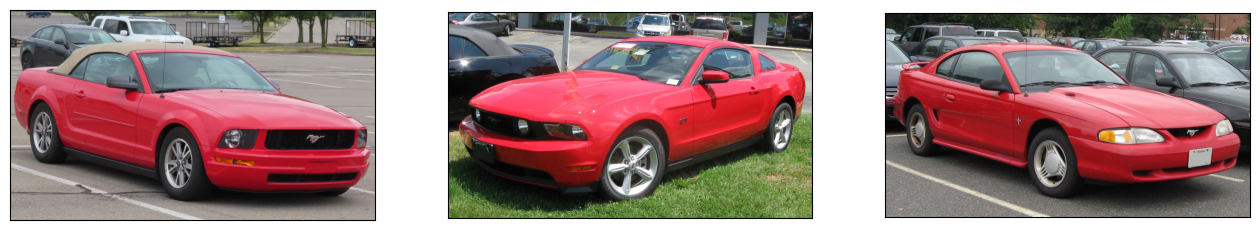

In [14]:
from llama_index.response.notebook_utils import display_source_node
from llama_index.schema import ImageNode

retrieved_image = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_image.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=200)

plot_images(retrieved_image)

In [15]:
response_3 = openai_mm_llm.complete(
    prompt="what are other similar cars?",
    image_documents=image_documents,
)

print(response_3)

The images you've provided appear to be specifications for the Tesla Model Y, which is an all-electric compact SUV. Based on the specifications shown, such as battery range, acceleration, and drive type, here are some other electric vehicles (EVs) that are similar in terms of performance and could be considered competitors:

1. Ford Mustang Mach-E: Ford's all-electric SUV offers similar acceleration and range, with various options for battery size and drivetrain (RWD or AWD).

2. Volkswagen ID.4: VW's electric SUV also competes in this space, with a focus on comfort and technology, offering both RWD and AWD variants.

3. Audi e-tron: Audi's luxury electric SUV provides a premium interior with advanced technology and comes in different configurations, including a performance model.

4. Hyundai Ioniq 5: This is a futuristic-looking electric SUV with a spacious interior, fast charging capabilities, and available in RWD or AWD.

5. Kia EV6: The EV6 is Kia's electric crossover with a sporty

### 2. Multi-Modal RAG Querying

In [16]:
from llama_index.prompts import PromptTemplate
from llama_index.query_engine import SimpleMultiModalQueryEngine

qa_tmpl_str = (
    "Context information is below.\n"
    "---------------------\n"
    "{context_str}\n"
    "---------------------\n"
    "Given the context information and not prior knowledge, "
    "answer the query.\n"
    "Query: {query_str}\n"
    "Answer: "
)
qa_tmpl = PromptTemplate(qa_tmpl_str)

query_engine = index.as_query_engine(
    multi_modal_llm=openai_mm_llm, text_qa_template=qa_tmpl
)

query_str = "Tell me more about the Porsche"
response = query_engine.query(query_str)

In [17]:
print(str(response))

The images you've provided appear to be related to the Porsche Taycan, which is a battery electric vehicle produced by the German automobile manufacturer Porsche. The first image shows a Porsche dealership with what seems to be a Taycan model on display inside the showroom. The second image is of a car that closely resembles the Porsche Mission E concept, which is the precursor to the Taycan.

The Porsche Taycan is notable for being Porsche's first series production electric car. It was fully revealed at the 2019 Frankfurt Motor Show, following the debut of its concept version, the Porsche Mission E, at the 2015 Frankfurt Motor Show. The Taycan has been designed with a strong emphasis on performance and features Porsche's first fully digital instrumentation. It comes with up to four digital displays and retains many design elements from the Mission E concept, such as the four-point LED daytime running headlamps and a full-width light band at the rear serving as taillights and turn sign

**Node ID:** d58a539b-5dd0-49db-bed4-ae517467964a<br>**Similarity:** 0.8290389191014838<br>**Text:** The Porsche Taycan is a battery electric saloon and shooting brake produced by German automobile manufacturer Porsche. The concept version of the Taycan, named the Porsche Mission E, debuted at the...<br>

**Node ID:** bdd90ce0-707f-4b14-abb1-871d1062d0b5<br>**Similarity:** 0.828128808011754<br>**Text:** === Porsche Mission E Cross Turismo ===
The Porsche Mission E Cross Turismo previewed the Taycan Cross Turismo, and was presented at the 2018 Geneva Motor Show. The design language of the Mission E...<br>

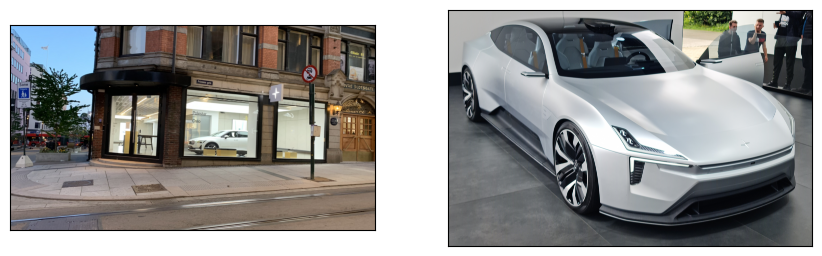

In [18]:
# show sources
from llama_index.response.notebook_utils import display_source_node

for text_node in response.metadata["text_nodes"]:
    display_source_node(text_node, source_length=200)
plot_images(
    [n.metadata["file_path"] for n in response.metadata["image_nodes"]]
)